#### Importing libraries

In [1]:
%store -r azdias_cleaned

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from collections import OrderedDict

import ast

# magic word for producing visualizations in notebook
%matplotlib inline

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

We'll do the following:

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once we've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since we'll be using them in the final Step 3.3.

In [1]:
%store -r azdias_cleaned

In [28]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797837 entries, 1 to 891220
Columns: 209 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_Young Couples With Children
dtypes: float64(209)
memory usage: 1.2 GB


In [31]:
from sklearn.cluster import KMeans
def cluster_scorer(data, nb_cluster):
    # data: pca object
    kmeans_k = KMeans(nb_cluster)
    model = kmeans_k.fit(data)
    return abs(model.score(data))

In [32]:
scores = []
for i in range(1, 16):
    scorer_i = cluster_scorer(selected_pca_transform, i)
    scores.append(scorer_i)
    print('cluster: %s - distance: %s' %(i, scorer_i))

cluster: 1 - distance: 162210981.17577395
cluster: 2 - distance: 154193293.49202096
cluster: 3 - distance: 148869064.6185898
cluster: 4 - distance: 144143872.20668238
cluster: 5 - distance: 141364761.65343997
cluster: 6 - distance: 139305618.8246575
cluster: 7 - distance: 136936169.64040667
cluster: 8 - distance: 135472114.91433242
cluster: 9 - distance: 134132027.95573781
cluster: 10 - distance: 133129333.25475404
cluster: 11 - distance: 131819362.29874377
cluster: 12 - distance: 131346934.84852096
cluster: 13 - distance: 130254994.95624195
cluster: 14 - distance: 128886752.97294386
cluster: 15 - distance: 127595434.58765525


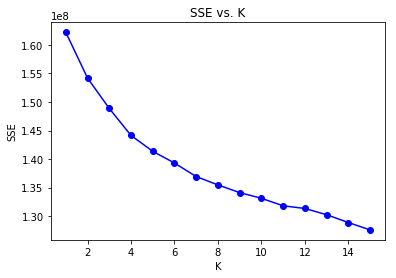

In [33]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(np.linspace(1,15,15), scores, linestyle='-', marker='o', color='blue')

In [34]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=11)
km_model = kmeans.fit(selected_pca_transform)
azdias_predicted_labels = km_model.predict(selected_pca_transform)

In [35]:
kmeans_centers = kmeans.cluster_centers_

### Discussion 3.1: Apply Clustering to General Population

After analizing the result graphic it seems appropiate to choose a number of 11 clusters since it seems to be a elbow from where the distance beetween points and the center doesnt decrese much after when adding more clusters (Note for me: It took a really long time to perform calculations on all those clusters).

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. (We can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [70]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [71]:
# checking the proportion of NaNs per feature in the dataframe
column_null_proportion_cust = pd.DataFrame(customers.isna().mean(axis=0)*100).reset_index()
column_null_proportion_cust.columns = ['features', 'missing_proportion']
display(column_null_proportion_cust[column_null_proportion_cust['missing_proportion']>20].head())

,features,missing_proportion
39,SOHO_KZ,24.312817
40,TITEL_KZ,24.312817
43,ALTER_HH,24.312817
44,ANZ_PERSONEN,24.312817
45,ANZ_TITEL,24.312817


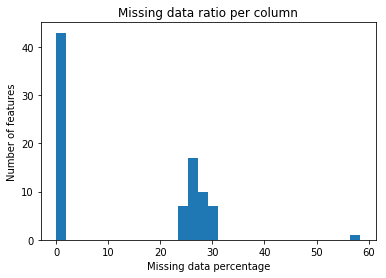

In [72]:
plt.figure()
plt.title('Missing data ratio per column')
plt.hist(column_null_proportion_cust['missing_proportion'], bins = 30)
plt.xlabel('Missing data percentage')
plt.ylabel('Number of features')
plt.show()

Given the plot above seem reasonable to drop columns with missing values above 35%, otherwise a lot of valuable data will be lost.

In [73]:
# checking the proportion of NaNs per feature in the dataframe
row_null_proportion_cust = pd.DataFrame(customers.isna().mean(axis=1)*100).reset_index()
row_null_proportion_cust.columns = ['features', 'missing_proportion']
display(row_null_proportion_cust[row_null_proportion_cust['missing_proportion']>20].head())

,features,missing_proportion
1,1,52.941176
10,10,40.000000
36,36,49.411765
37,37,49.411765
38,38,49.411765


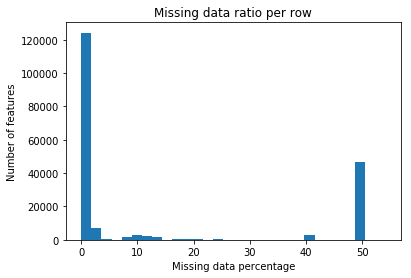

In [74]:
plt.figure()
plt.title('Missing data ratio per row')
plt.hist(row_null_proportion_cust['missing_proportion'], bins = 30)
plt.xlabel('Missing data percentage')
plt.ylabel('Number of features')
plt.show()

It seems that there's a lot of missing values for a large amount of rows. It will be descarted as well since it's likely to mess the model.

In [78]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
from clean_data_helper import clean_data

row_proportion_thresh=30
col_proportion_thresh=35
outlier_threshold =0.001 # threshold percentage
customer_df_cleaned = clean_data(customers, row_proportion_thresh, col_proportion_thresh, outlier_threshold)

outlier columns removed: 
AGER_TYP        50.475863
GEBURTSJAHR     48.537975
TITEL_KZ        98.793647
ALTER_HH        35.870745
KK_KUNDENTYP    58.406382
KBA05_BAUMAX    57.153069
dtype: float64


In [79]:
print('customers dataframe cleaned shape:', customer_df_cleaned.shape)

customers dataframe cleaned shape: (141690, 209)


In [80]:
len(scale.mean_) # it should be the same number of columns to perform the transform on scale

209

In [82]:
cols_c = customer_df_cleaned.columns.tolist()
cols_p = azdias_cleaned.columns.tolist()

In [83]:
feat_in_cust_not_in_pop= np.setdiff1d(cols_c,cols_p).tolist()
print(feat_in_cust_not_in_pop)

[]


In [84]:
# scaling, removing nans and predicting
customer_df_cleaned[customer_df_cleaned.columns] = scale.transform(imp.transform(customer_df_cleaned))

In [85]:
# pca
customers_pca = selected_pca.transform(customer_df_cleaned)
customers_azdias_predicted_labels = km_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [86]:
# plotting function definition
def compare_clusters(clust_a, clust_b, label_clust_a, label_clust_b):
    # proportions by value
    series_a = pd.Series(clust_a)
    series_b = pd.Series(clust_b)
    values_count_a = series_a.value_counts()
    values_count_b = series_b.value_counts()
    values_prop_a = values_count_a.sort_index() / values_count_a.sum()
    values_prop_b = values_count_b.sort_index() / values_count_b.sum()

    # merge columns
    df = pd.merge(values_prop_a.reset_index(), values_prop_b.reset_index(), 
                    on='index', how='outer').fillna(0)

    # reshape dataframe
    df.columns = ['index', label_clust_a, label_clust_b]
    df = df.set_index('index').stack().reset_index()
    df.columns = ['Cluster Index', 'Dataset', 'Proportion']
    df = df.fillna(0)
    
    # plot comparison
    plt.figure(figsize=(16, 6))
    g = sns.barplot(data=df, x='Cluster Index', y='Proportion', hue='Dataset')
    g.set_title('Cluster comparison proportion between population and customer')

    plt.show()
    
    return df

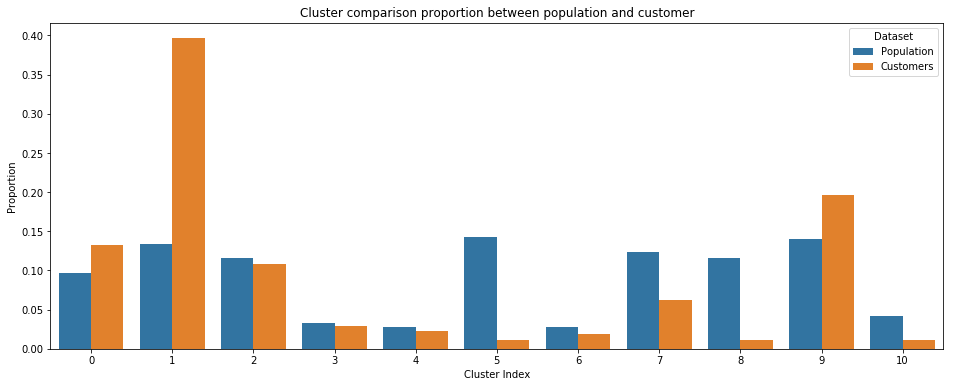

In [87]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
df_comparison = compare_clusters(azdias_predicted_labels, 
                                 customers_azdias_predicted_labels, 
                                 'Population', 
                                 'Customers'
                )

Cluster 2, 3, 4 and 6 in the plot above seem to have a matching beetween general population and customers so those can be a target audience for the company.

There is a higher proportion of people in cluster 0, 1 and 9 for the customer data compared to the general population, this suggests people in that cluster to be a target audience for the company.

The proportion of the data in remaining clusters being larger in the general population than the customer data that group of persons to be outside of the target demographics.

In [96]:
# get center in original space
centers = selected_pca.inverse_transform(kmeans_centers)
centers = scale.inverse_transform(centers)

In [89]:
# Display the true centers calculated from population dataset
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
pop_centers = pd.DataFrame(np.round(centers, 4), columns = azdias_cleaned.columns)
pop_centers.index = segments

From section 2.3 we had the following relevant positive correlated features per principal components:
- **Component 1**: 'FINANZ_MINIMALIST', 'MOBI_REGIO', 'LP_LEBENSPHASE_FEIN', 'KBA05_ANTG1', 'KBA05_GBZ' : **income**
    
- **Component 2**: 'FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 'SEMIO_REL', 'SEMIO_TRADV', 'DECADE_90s' : **finance**

- **Component 3**: 'PLZ8_ANTG4','KBA05_ANTG4','KBA05_ANTG3','PLZ8_ANTG3','PLZ8_ANTG2' : **personality**

In [91]:
# analizing strongly correlated weighted features

comp1_high_relevant_features = ['FINANZ_MINIMALIST', 'MOBI_REGIO', 'LP_LEBENSPHASE_FEIN', 'KBA05_ANTG1', 'KBA05_GBZ']          
comp2_high_relevant_features = ['FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 'SEMIO_REL', 'SEMIO_TRADV', 'DECADE_90s']          
comp3_high_relevant_features = ['PLZ8_ANTG4','KBA05_ANTG4','KBA05_ANTG3','PLZ8_ANTG3','PLZ8_ANTG2']

relevant_features = comp1_high_relevant_features + comp2_high_relevant_features + comp3_high_relevant_features

In [92]:
# overrated clusters
overrated_segments = ['Segment 2']

# underrated clusters
underrated_segments = ['Segment 4']

relevant_segments = overrated_segments + underrated_segments

In [93]:
def display_deviation_from_mean_and_variance_per_df(centers, segments, df, df_label, features):
    
    segment_centers = centers.loc[segments,]
    # analizing median since its less propense to noise
    print('True population centers offset from %s MEDIAN for relevant segments'%(df_label.upper(), ))
    segment_centers_median_deviation= segment_centers - np.round(scale.inverse_transform((df).median()))
    display(segment_centers_median_deviation[features])

In [94]:
# over and under represented cluster: population
display_deviation_from_mean_and_variance_per_df(
    pop_centers, relevant_segments, azdias_cleaned, 'population', relevant_features
)

True population centers offset from POPULATION MEDIAN for relevant segments


,FINANZ_MINIMALIST,MOBI_REGIO,LP_LEBENSPHASE_FEIN,KBA05_ANTG1,KBA05_GBZ,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,SEMIO_REL,SEMIO_TRADV,DECADE_90s,PLZ8_ANTG4,KBA05_ANTG4,KBA05_ANTG3,PLZ8_ANTG3,PLZ8_ANTG2
Segment 2,0.1261,0.0422,0.0578,0.5074,0.2084,-0.3041,-1.4259,-2.0491,-1.6285,0.0243,-0.4479,0.2437,0.7144,-0.5431,-0.2434
Segment 4,-0.3852,-0.6966,-0.7487,-0.1191,-0.3367,0.7439,-0.1335,0.1305,-0.1401,0.3118,0.1151,0.5097,0.8886,0.1564,0.2094


In [95]:
# over and underrepresented cluster: customers
display_deviation_from_mean_and_variance_per_df(
    pop_centers, relevant_segments, customer_df_cleaned, 'customers', relevant_features
)

True population centers offset from CUSTOMERS MEDIAN for relevant segments


,FINANZ_MINIMALIST,MOBI_REGIO,LP_LEBENSPHASE_FEIN,KBA05_ANTG1,KBA05_GBZ,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,SEMIO_REL,SEMIO_TRADV,DECADE_90s,PLZ8_ANTG4,KBA05_ANTG4,KBA05_ANTG3,PLZ8_ANTG3,PLZ8_ANTG2
Segment 2,-1.8739,-0.9578,-6.9422,-0.4926,-0.7916,-0.3041,0.5741,-1.0491,-0.6285,0.0243,0.5521,0.2437,0.7144,0.4569,-0.2434
Segment 4,-2.3852,-1.6966,-7.7487,-1.1191,-1.3367,0.7439,1.8665,1.1305,0.8599,0.3118,1.1151,0.5097,0.8886,1.1564,0.2094


### Analizing clusters relation beetween population and customers:

First thing to check is that the distance from records to cluster centers are similar. This is true for most of the features in both population and customer dataset which means that the clusters describe well enough customers patterns. It gets easy to visualize per segment and component:

* **Overrated cluster: Segment 2**

| component number | segments (clusters)  | FINANZ_MINIMALIST | MOBI_REGIO | LP_LEBENSPHASE_FEIN | KBA05_ANTG1 | KBA05_GBZ |
|------------------|----------------------|-------------------|------------|---------------------|-------------|-----------|
| 1                | Segment 2 population | -1.9346           | -2.7252    | -12.1915            | -0.7515     | -2.8152   |
| 1                | Segment 2 customers  | -3.9346           | -3.7252    | -19.1915            | -1.7515     | -3.8152   |
| 2                | Segment 2 population | -2.2354           | -3.5600    | -4.3658             | -4.2350     | -0.3606   |
| 2                | Segment 2 customers  | -2.2354           | -1.5600    | -3.3658             | -3.2350     | -0.3606   |
| 3                | Segment 2 population | -1.3107           | -0.3031    | -0.3898             | -2.3604     | -3.2807   |
| 3                | Segment 2 customers  | -0.3107           | -0.3031    | -0.3898             | -1.3604     | -3.2807   |



* **Under rated clusters: Segment 4** 

| component number | segments (clusters)  | FINANZ_MINIMALIST | MOBI_REGIO | LP_LEBENSPHASE_FEIN | KBA05_ANTG1 | KBA05_GBZ |
|------------------|----------------------|-------------------|------------|---------------------|-------------|-----------|
| 1                | Segment 4 population | -4.2467           | -3.5759    | -13.5778            | -1.5177     | -3.5121   |
| 1                | Segment 4 customers  | -6.2467           | -4.5759    | -20.5778            | -2.5177     | -4.5121   |
| 2                | Segment 4 population | -1.1386           | -1.7925    | -3.1583             | -2.9965     | 1.1073    |
| 2                | Segment 4 customers  | -1.1386           | 0.2075     | -2.1583             | -1.9965     | 1.1073    |
| 3                | Segment 4 population | -0.8940           | -0.1174    | -0.0540             | -1.7910     | -2.9013   |
| 3                | Segment 4 customers  | 0.1060            | -0.1174    | -0.0540             | -0.7910     | -2.9013   |


### Identifying customer segments in relevant clusters

* **Overrated cluster: Segment 2**

It can be seen that features from component 1 are the features that represent the second cluster with highest values over the other features. The type of customers in this cluster are the ones whom can be identify as **finantialy stable**, have **reduce family elements**.

|  FINANZ_MINIMALIST |        MOBI_REGIO | LP_LEBENSPHASE_FEIN |                                  KBA05_ANTG1 |
| -----------------: | ----------------: | ------------------: | -------------------------------------------: |
| Financial typology | Movement patterns |          Life stage | Number of 1-2 family houses in the microcell |


* **Under rated clusters: Segment 4**

It can be seen that features from component 3 are the features that represent the second cluster with highest values over the other features. It also can be seen that DECADE_90s fits in this group as well. This cluster clearly identifies people whit **higher number of family members** and segregated by **region**. 

|                   PLZ8_ANTG4                   |                 KBA05_ANTG4                  |                  KBA05_ANTG3                  |                   PLZ8_ANTG3                    |
| :--------------------------------------------: | :------------------------------------------: | :-------------------------------------------: | :---------------------------------------------: |
| Number of 10+ family houses in the PLZ8 region | Number of 10+ family houses in the microcell | Number of 6-10 family houses in the microcell | Number of 6-10 family houses in the PLZ8 region |


### Discussion 3.3: Compare Customer Data to Demographics Data

After analyzing the plot results about the clusters per origin_data_frame (population, customers) and the corresponding features associated with the principal components it can be seen that there is a valuable insight this analysis that can be used to select the appropriate target population after identifying customer segments.
So in conclution, the target population should be in the active middle class, related with economical status (not sure if that is the correct way to say it but what I'm trying to mean is that one of the target population is the one that has money, in the middle-class range).